Epoch 1/200


c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.5385 - mae: 0.5621 - val_loss: 0.4395 - val_mae: 0.5037
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.4857 - mae: 0.5118 - val_loss: 0.3861 - val_mae: 0.4469
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.4484 - mae: 0.4761 - val_loss: 0.3376 - val_mae: 0.3878
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.4106 - mae: 0.4298 - val_loss: 0.2907 - val_mae: 0.3195
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3600 - mae: 0.3803 - val_loss: 0.2509 - val_mae: 0.2455
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3281 - mae: 0.3404 - val_loss: 0.2187 - val_mae: 0.1755
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2934 - mae: 0.3100 - val_loss: 0.2039 - val_mae: 0.1621
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2722 - mae: 0.2676 - val_loss: 0.1985 - val_mae: 0.1547
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2541 - mae: 0.2437 - val_l

c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) Deja

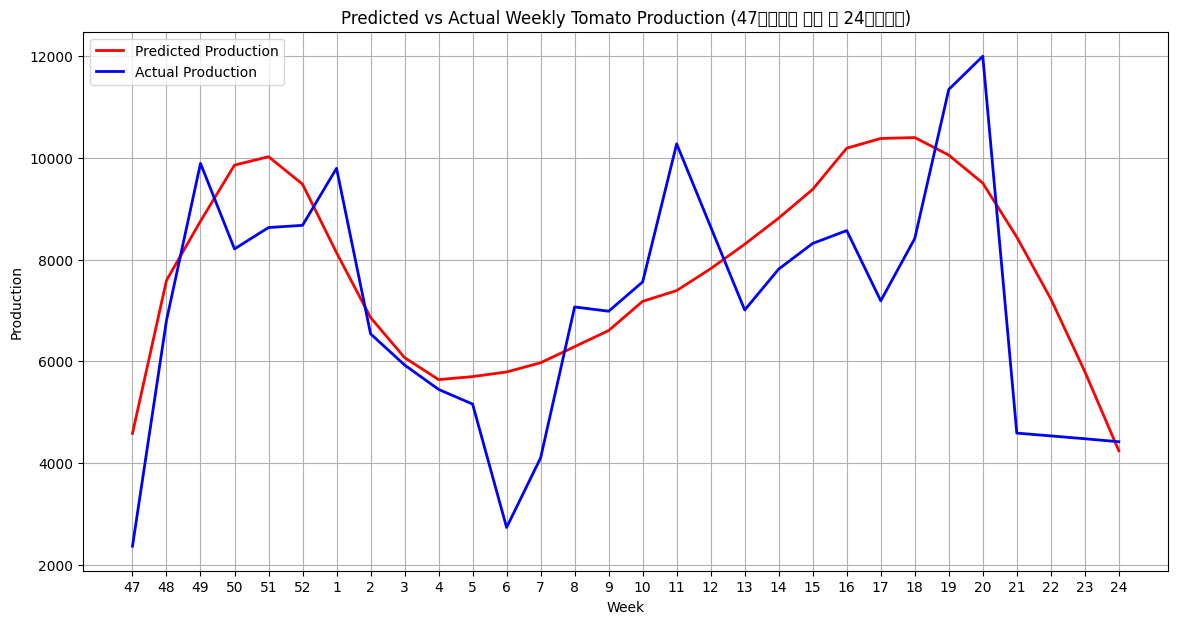

In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기
yield_data = pd.read_csv('전북군산생산량_변환.csv')
env_data = pd.read_csv('전북군산환경데이터_변환.csv')

# 2. 날짜 데이터를 변환하고 주차 계산
env_data['measDtStr'] = pd.to_datetime(env_data['measDtStr'], format='%Y%m%d%H%M%S')
env_data['연도'] = env_data['measDtStr'].dt.year
env_data['주차'] = env_data['measDtStr'].dt.isocalendar().week

# 3. 적산 계산을 위한 데이터 그룹화 (주차별로 누적 합계 계산)
env_weekly_cumulative = env_data.groupby(['연도', '주차']).agg({
    'inTp': 'sum',     # 온도 적산
    'inHd': 'sum',     # 습도 적산
    'inCo2': 'sum',    # CO2 적산
    'outTp': 'sum'     # 추가된 outTp 적산
}).reset_index()

# 4. 생산량 데이터와 병합
yield_data = yield_data.rename(columns={'item.frmhsId': 'frmhsId'})
merged_data = pd.merge(
    env_weekly_cumulative, 
    yield_data[['연도', '주차', '생산량']],
    on=['연도', '주차'],
    how='inner').dropna(subset=['생산량'])

# 5. 특성과 타겟 데이터 분리
X = merged_data[['inTp', 'inHd', 'inCo2', 'outTp']].values  # 입력 변수 (온도, 습도, CO2, 추가된 outTp 적산값)
y = merged_data['생산량'].values  # 타겟 변수 (생산량)

# 6. 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 타겟 데이터 스케일링
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# 7. 시계열 데이터 준비
timesteps = 12  # 12주 간 데이터를 사용
forecast_weeks = 1  # 1주차 예측

# 시퀀스를 생성
X_sequences = []
y_sequences = []
for i in range(len(X_scaled) - timesteps - forecast_weeks + 1):
    X_sequences.append(X_scaled[i:i+timesteps])
    y_sequences.append(y_scaled[i+timesteps:i+timesteps+forecast_weeks].flatten())

# 시퀀스를 넘파이 배열로 변환
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# 8. 학습 데이터와 테스트 데이터로 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# 9. LSTM 모델 구축
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.2),  # 과적합 방지를 위한 드롭아웃
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),  # 과적합 방지를 위한 드롭아웃
    tf.keras.layers.GRU(50, activation='relu'),  # GRU 층 추가
    tf.keras.layers.Dropout(0.2),  # 과적합 방지를 위한 드롭아웃
    tf.keras.layers.Dense(forecast_weeks)  # 예측할 주차 수 만큼의 출력 뉴런
])

# RMSprop 최적화 알고리즘으로 모델 컴파일
optimizer = RMSprop(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=64, callbacks=[early_stopping])

# 전체 데이터로 시퀀스 생성
X_full_sequences = []
for i in range(len(X_scaled) - timesteps + 1):
    X_full_sequences.append(X_scaled[i:i+timesteps])
X_full_sequences = np.array(X_full_sequences)

# 전체 데이터로 예측 수행
full_predictions = model.predict(X_full_sequences)
full_predictions_inverse = scaler_y.inverse_transform(full_predictions)

# 주차별 예측된 생산량 출력 (47주차부터 다음 해 24주차까지)
weeks_extended_full = np.concatenate([np.arange(47, 53), np.arange(1, 25)])  # 47주차부터 다음 해 24주차까지
filtered_predictions = full_predictions_inverse[:len(weeks_extended_full)]  # 주차 범위에 맞춰 예측값 슬라이싱

# 1. 데이터 로드
yield_data = pd.read_csv('전북군산생산량_변환.csv')

# 2. 47주차부터 다음 해 24주차까지 필터링
filtered_yield_data = yield_data[(yield_data['주차'] >= 47) | (yield_data['주차'] <= 24)]
filtered_yield_data = filtered_yield_data.sort_values(by=['연도', '주차'])

# 4. 각 주차에 대응하는 생산량 데이터 가져오기
actual_production = filtered_yield_data['생산량'].values[:len(weeks_extended_full)]  # 주차에 맞춰 데이터 슬라이싱

# 그래프 시각화 (필요시)
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(weeks_extended_full)), filtered_predictions.flatten(), label='Predicted Production', color='red', linewidth=2)
plt.plot(np.arange(len(weeks_extended_full)), actual_production, label='Actual Production', color='blue', linewidth=2)
plt.xticks(ticks=np.arange(len(weeks_extended_full)), labels=weeks_extended_full)
plt.title('Predicted vs Actual Weekly Tomato Production (47주차부터 다음 해 24주차까지)')
plt.xlabel('Week')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
from sklearn.metrics import mean_squared_error
import numpy as np

# RMSE 계산
rmse = np.sqrt(mean_squared_error(actual_production, filtered_predictions))
print("RMSE:", rmse)


RMSE: 1319.4458629745668


In [18]:
# 5. 실제 생산량 및 예측된 생산량을 모두 출력
print("주차별 실제 생산량 및 예측된 생산량:")
for i in range(len(weeks_extended_full)):
    print(f"{weeks_extended_full[i]}주차 실제 생산량 : {actual_production[i]}, 예측 생산량 : {filtered_predictions.flatten()[i]}")

주차별 실제 생산량 및 예측된 생산량:
47주차 실제 생산량 : 2368, 예측 생산량 : 3565.2978515625
48주차 실제 생산량 : 6804, 예측 생산량 : 7412.76171875
49주차 실제 생산량 : 9888, 예측 생산량 : 9551.978515625
50주차 실제 생산량 : 8208, 예측 생산량 : 10404.3095703125
51주차 실제 생산량 : 8628, 예측 생산량 : 10434.576171875
52주차 실제 생산량 : 8671, 예측 생산량 : 9391.4228515625
1주차 실제 생산량 : 9792, 예측 생산량 : 8251.615234375
2주차 실제 생산량 : 6540, 예측 생산량 : 6235.58251953125
3주차 실제 생산량 : 5928, 예측 생산량 : 5387.23779296875
4주차 실제 생산량 : 5448, 예측 생산량 : 4609.57421875
5주차 실제 생산량 : 5160, 예측 생산량 : 4284.326171875
6주차 실제 생산량 : 2736, 예측 생산량 : 4676.5986328125
7주차 실제 생산량 : 4104, 예측 생산량 : 5437.00537109375
8주차 실제 생산량 : 7068, 예측 생산량 : 6666.15771484375
9주차 실제 생산량 : 6984, 예측 생산량 : 7692.3056640625
10주차 실제 생산량 : 7560, 예측 생산량 : 8369.7841796875
11주차 실제 생산량 : 10272, 예측 생산량 : 8994.4462890625
12주차 실제 생산량 : 8640, 예측 생산량 : 9394.072265625
13주차 실제 생산량 : 7008, 예측 생산량 : 9394.8291015625
14주차 실제 생산량 : 7812, 예측 생산량 : 9565.6279296875
15주차 실제 생산량 : 8316, 예측 생산량 : 9456.330078125
16주차 실제 생산량 : 8568, 예측 생산량 : 9829.763671875
1

In [3]:
import pandas as pd

# 데이터 파일 경로
file_path = 'C:/Users/a/Desktop/tomato/tlstm/전북군산생산량_변환.csv'

# 데이터 불러오기
data = pd.read_csv(file_path)

# 21주차와 25주차 값 가져오기
start_value = data.loc[data['주차'] == 21, '생산량'].values[0]
end_value = data.loc[data['주차'] == 24, '생산량'].values[0]

# 22주차~24주차의 값을 선형 보간으로 채우기
data.loc[data['주차'] == 22, '생산량'] = start_value + (end_value - start_value) * 1 / 4
data.loc[data['주차'] == 23, '생산량'] = start_value + (end_value - start_value) * 2 / 4
data.loc[data['주차'] == 24, '생산량'] = start_value + (end_value - start_value) * 3 / 4

# 수정된 데이터를 새로운 파일로 저장
output_path = 'C:/Users/a/Desktop/tomato/tlstm/전북군산생산량_보간_최종.csv'
data.to_csv(output_path, index=False)

print(f"보간된 파일 저장 완료: {output_path}")


보간된 파일 저장 완료: C:/Users/a/Desktop/tomato/tlstm/전북군산생산량_보간_최종.csv


C:\Users\a\AppData\Local\Temp\ipykernel_48768\705922545.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3442.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['주차'] == 22, '생산량'] = start_value + (end_value - start_value) * 1 / 4


Epoch 1/200


c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4296 - mae: 0.6148 - val_loss: 0.3741 - val_mae: 0.5978
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.4064 - mae: 0.5954 - val_loss: 0.3551 - val_mae: 0.5815
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3907 - mae: 0.5820 - val_loss: 0.3394 - val_mae: 0.5677
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3777 - mae: 0.5707 - val_loss: 0.3251 - val_mae: 0.5549
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3660 - mae: 0.5602 - val_loss: 0.3119 - val_mae: 0.5427
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3551 - mae: 0.5503 - val_loss: 0.3001 - val_mae: 0.5315
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3450 - mae: 0.5409 - val_loss: 0.2886 - val_mae: 0.5204
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3352 - mae: 0.5316 - val_loss: 0.2775 - val_mae: 0.5094
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3257 - mae: 0.5225 - val_l

c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) Deja

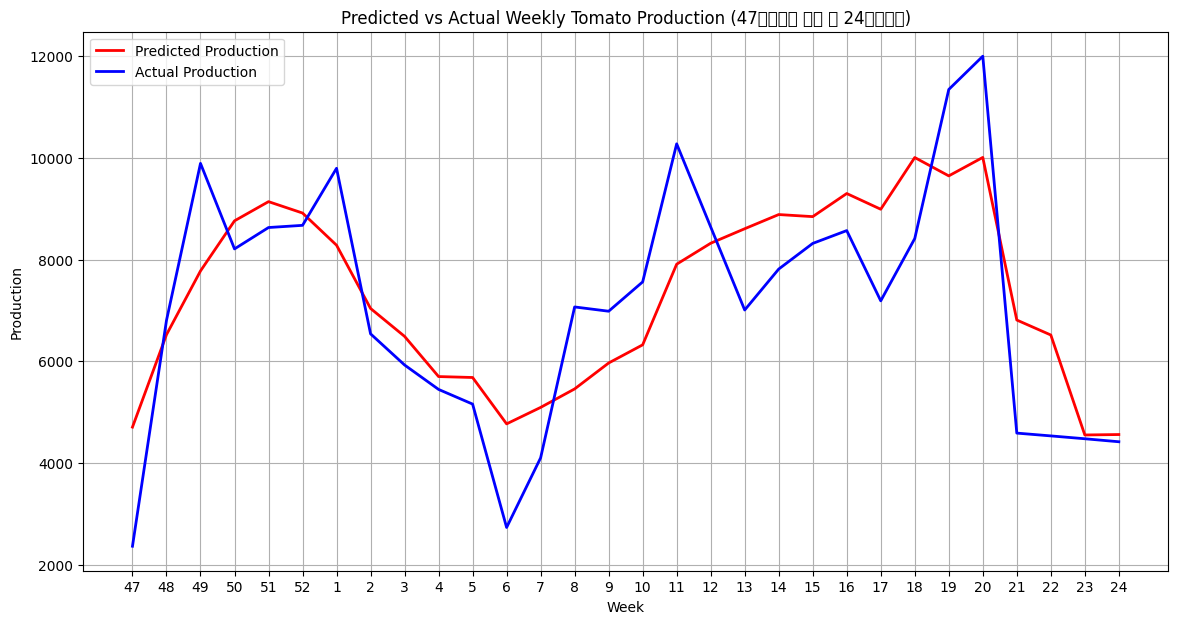

In [3]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기
yield_data = pd.read_csv('전북군산생산량_변환.csv')
env_data = pd.read_csv('전북군산환경데이터_변환.csv')

# 2. 날짜 데이터를 변환하고 주차 계산
env_data['measDtStr'] = pd.to_datetime(env_data['measDtStr'], format='%Y%m%d%H%M%S')
env_data['연도'] = env_data['measDtStr'].dt.year
env_data['주차'] = env_data['measDtStr'].dt.isocalendar().week

# 3. 주차별로 평균, 최소, 최대값 계산
env_weekly_features = env_data.groupby(['연도', '주차']).agg({
    'inTp': ['mean', 'min', 'max'],  # 온도 (평균, 최소, 최대)
    'inHd': ['mean', 'min', 'max'],  # 습도 (평균, 최소, 최대)
    'inCo2': ['mean', 'min', 'max'],  # CO2 농도 (평균, 최소, 최대)
    'outTp': ['mean', 'min', 'max']  # 외부 온도 (평균, 최소, 최대)
}).reset_index()

# 열 이름을 단순화
env_weekly_features.columns = [
    '연도', '주차',
    'inTp_mean', 'inTp_min', 'inTp_max',       # 내부 온도 열
    'inHd_mean', 'inHd_min', 'inHd_max',       # 내부 습도 열
    'inCo2_mean', 'inCo2_min', 'inCo2_max',    # CO2 농도 열
    'outTp_mean', 'outTp_min', 'outTp_max'     # 외부 온도 열
]

# 4. 생산량 데이터와 면적 정보 병합
yield_data = yield_data.rename(columns={'item.frmhsId': 'frmhsId'})  # 열 이름 통일
merged_data = pd.merge(
    env_weekly_features,
    yield_data[['연도', '주차', '생산량', '면적']],  # 면적 추가
    on=['연도', '주차'],
    how='inner'
).dropna(subset=['생산량', '면적'])  # 결측치 제거

# 5. 특성과 타겟 데이터 분리
X = merged_data[['inTp_mean', 'inTp_min', 'inTp_max', 
                 'inHd_mean', 'inHd_min', 'inHd_max', 
                 'inCo2_mean', 'inCo2_min', 'inCo2_max', 
                 'outTp_mean', 'outTp_min', 'outTp_max', 
                 '면적'  # 면적 특성 추가
                ]].values
y = merged_data['생산량'].values

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 타겟 데이터 스케일링
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# 시계열 데이터 준비
timesteps = 12  # 12주 간 데이터를 사용
forecast_weeks = 1  # 1주차 예측

# 시퀀스를 생성
X_sequences = []
y_sequences = []
for i in range(len(X_scaled) - timesteps - forecast_weeks + 1):
    X_sequences.append(X_scaled[i:i+timesteps])
    y_sequences.append(y_scaled[i+timesteps:i+timesteps+forecast_weeks].flatten())

# 시퀀스를 넘파이 배열로 변환
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# 학습 데이터와 테스트 데이터로 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, activation='relu', return_sequences=True)),
    tf.keras.layers.GRU(100, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(100, activation='relu'),
    tf.keras.layers.Dense(forecast_weeks)
])

# 최적화 알고리즘과 학습률 수정
optimizer = RMSprop(learning_rate=0.0001)  # 학습률을 더 낮춤

# 모델 컴파일
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# EarlyStopping 설정 (기존 patience 유지)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습 (배치 크기 조정)
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=32, callbacks=[early_stopping])


# 전체 데이터로 시퀀스 생성
X_full_sequences = []
for i in range(len(X_scaled) - timesteps + 1):
    X_full_sequences.append(X_scaled[i:i+timesteps])
X_full_sequences = np.array(X_full_sequences)

# 전체 데이터로 예측 수행
full_predictions = model.predict(X_full_sequences)
full_predictions_inverse = scaler_y.inverse_transform(full_predictions)

# 주차별 예측된 생산량 출력 (47주차부터 다음 해 24주차까지)
weeks_extended_full = np.concatenate([np.arange(47, 53), np.arange(1, 25)])  # 47주차부터 다음 해 24주차까지
filtered_predictions = full_predictions_inverse[:len(weeks_extended_full)]  # 주차 범위에 맞춰 예측값 슬라이싱

# 실제 생산량 데이터 로드 및 주차 필터링
filtered_yield_data = yield_data[(yield_data['주차'] >= 47) | (yield_data['주차'] <= 24)]
filtered_yield_data = filtered_yield_data.sort_values(by=['연도', '주차'])
actual_production = filtered_yield_data['생산량'].values[:len(weeks_extended_full)]

# 그래프 시각화
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(weeks_extended_full)), filtered_predictions.flatten(), label='Predicted Production', color='red', linewidth=2)
plt.plot(np.arange(len(weeks_extended_full)), actual_production, label='Actual Production', color='blue', linewidth=2)
plt.xticks(ticks=np.arange(len(weeks_extended_full)), labels=weeks_extended_full)
plt.title('Predicted vs Actual Weekly Tomato Production (47주차부터 다음 해 24주차까지)')
plt.xlabel('Week')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
from sklearn.metrics import mean_squared_error
import numpy as np

# RMSE 계산
rmse = np.sqrt(mean_squared_error(actual_production, filtered_predictions))
print("RMSE:", rmse)


RMSE: 1363.6250489078986


Epoch 1/200


c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4239 - mae: 0.6098 - val_loss: 0.3616 - val_mae: 0.5873
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.4006 - mae: 0.5900 - val_loss: 0.3395 - val_mae: 0.5678
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3826 - mae: 0.5743 - val_loss: 0.3204 - val_mae: 0.5505
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3669 - mae: 0.5602 - val_loss: 0.3036 - val_mae: 0.5347
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3526 - mae: 0.5471 - val_loss: 0.2882 - val_mae: 0.5199
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3395 - mae: 0.5348 - val_loss: 0.2738 - val_mae: 0.5054
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3272 - mae: 0.5229 - val_loss: 0.2602 - val_mae: 0.4914
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3155 - mae: 0.5112 - val_loss: 0.2470 - val_mae: 0.4775
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3039 - mae: 0.4995 - val_l

c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) Deja

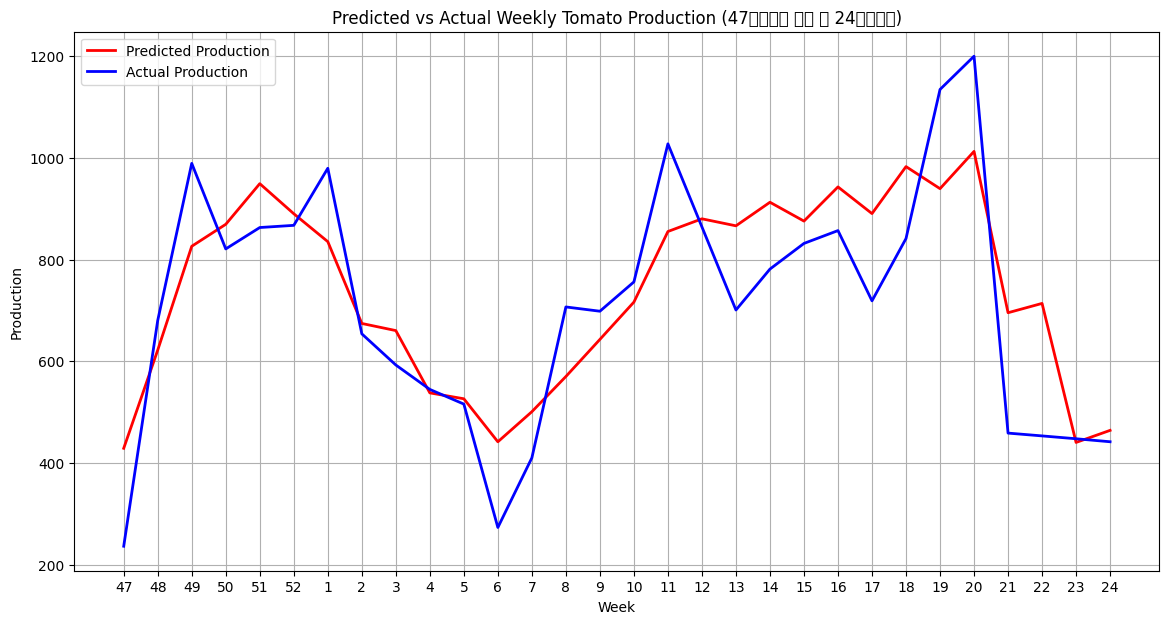

In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기
yield_data = pd.read_csv('전북군산생산량_변환.csv')
env_data = pd.read_csv('전북군산환경데이터_변환.csv')

# 2. 날짜 데이터를 변환하고 주차 계산
env_data['measDtStr'] = pd.to_datetime(env_data['measDtStr'], format='%Y%m%d%H%M%S')
env_data['연도'] = env_data['measDtStr'].dt.year
env_data['주차'] = env_data['measDtStr'].dt.isocalendar().week

# 3. 주차별로 평균, 최소, 최대값 계산
env_weekly_features = env_data.groupby(['연도', '주차']).agg({
    'inTp': ['mean', 'min', 'max'],  # 온도 (평균, 최소, 최대)
    'inHd': ['mean', 'min', 'max'],  # 습도 (평균, 최소, 최대)
    'inCo2': ['mean', 'min', 'max'],  # CO2 농도 (평균, 최소, 최대)
    'outTp': ['mean', 'min', 'max']  # 외부 온도 (평균, 최소, 최대)
}).reset_index()

# 열 이름을 단순화
env_weekly_features.columns = [
    '연도', '주차',
    'inTp_mean', 'inTp_min', 'inTp_max',       # 내부 온도 열
    'inHd_mean', 'inHd_min', 'inHd_max',       # 내부 습도 열
    'inCo2_mean', 'inCo2_min', 'inCo2_max',    # CO2 농도 열
    'outTp_mean', 'outTp_min', 'outTp_max'     # 외부 온도 열
]

# 4. 생산량 데이터와 면적 정보 병합
yield_data = yield_data.rename(columns={'item.frmhsId': 'frmhsId'})  # 열 이름 통일

# 생산량을 1평당으로 변환
yield_data['생산량'] = yield_data['생산량'] / 10

merged_data = pd.merge(
    env_weekly_features,
    yield_data[['연도', '주차', '생산량', '면적']],  # 면적 추가
    on=['연도', '주차'],
    how='inner'
).dropna(subset=['생산량', '면적'])  # 결측치 제거

# 5. 특성과 타겟 데이터 분리
X = merged_data[['inTp_mean', 'inTp_min', 'inTp_max', 
                 'inHd_mean', 'inHd_min', 'inHd_max', 
                 'inCo2_mean', 'inCo2_min', 'inCo2_max', 
                 'outTp_mean', 'outTp_min', 'outTp_max', 
                 '면적'  # 면적 특성 추가
                ]].values
y = merged_data['생산량'].values

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 타겟 데이터 스케일링
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# 시계열 데이터 준비
timesteps = 12  # 12주 간 데이터를 사용
forecast_weeks = 1  # 1주차 예측

# 시퀀스를 생성
X_sequences = []
y_sequences = []
for i in range(len(X_scaled) - timesteps - forecast_weeks + 1):
    X_sequences.append(X_scaled[i:i+timesteps])
    y_sequences.append(y_scaled[i+timesteps:i+timesteps+forecast_weeks].flatten())

# 시퀀스를 넘파이 배열로 변환
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# 학습 데이터와 테스트 데이터로 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, activation='relu', return_sequences=True)),
    tf.keras.layers.GRU(100, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(100, activation='relu'),
    tf.keras.layers.Dense(forecast_weeks)
])

# 최적화 알고리즘과 학습률 수정
optimizer = RMSprop(learning_rate=0.0001)  # 학습률을 더 낮춤

# 모델 컴파일
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# EarlyStopping 설정 (기존 patience 유지)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습 (배치 크기 조정)
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=32, callbacks=[early_stopping])


# 전체 데이터로 시퀀스 생성
X_full_sequences = []
for i in range(len(X_scaled) - timesteps + 1):
    X_full_sequences.append(X_scaled[i:i+timesteps])
X_full_sequences = np.array(X_full_sequences)

# 전체 데이터로 예측 수행
full_predictions = model.predict(X_full_sequences)
full_predictions_inverse = scaler_y.inverse_transform(full_predictions)

# 주차별 예측된 생산량 출력 (47주차부터 다음 해 24주차까지)
weeks_extended_full = np.concatenate([np.arange(47, 53), np.arange(1, 25)])  # 47주차부터 다음 해 24주차까지
filtered_predictions = full_predictions_inverse[:len(weeks_extended_full)]  # 주차 범위에 맞춰 예측값 슬라이싱

# 실제 생산량 데이터 로드 및 주차 필터링
filtered_yield_data = yield_data[(yield_data['주차'] >= 47) | (yield_data['주차'] <= 24)]
filtered_yield_data = filtered_yield_data.sort_values(by=['연도', '주차'])
actual_production = filtered_yield_data['생산량'].values[:len(weeks_extended_full)]

# 그래프 시각화
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(weeks_extended_full)), filtered_predictions.flatten(), label='Predicted Production', color='red', linewidth=2)
plt.plot(np.arange(len(weeks_extended_full)), actual_production, label='Actual Production', color='blue', linewidth=2)
plt.xticks(ticks=np.arange(len(weeks_extended_full)), labels=weeks_extended_full)
plt.title('Predicted vs Actual Weekly Tomato Production (47주차부터 다음 해 24주차까지)')
plt.xlabel('Week')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
from sklearn.metrics import mean_squared_error
import numpy as np

# RMSE 계산
rmse = np.sqrt(mean_squared_error(actual_production, filtered_predictions))
print("RMSE:", rmse)


RMSE: 128.2121409566644
